<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/Weights_freezeWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import time

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import and process the data

In [69]:
#import dataset(comes with colab!)
data=np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
#extract labels(number IDs) and remove from data
labels=data[:,0]
data=data[:,1:]
#normalize the data to a range of [0 1]
dataNorm=data/np.max(data)


In [70]:
#step 1: convert to tensor
dataT=torch.tensor(dataNorm).float()
labelsT=torch.tensor(labels).long()

#step 2: use scikitlearn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(dataT,labelsT,test_size=0.1)

#step 3:convert into Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)

#step 4: translate into dataLoader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Create the DL model

In [71]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer (using SGD to slow down learning!)
  optimizer = torch.optim.SGD(net.parameters(),lr=.001)

  return net,lossfun,optimizer


Brief inspection of requires_grad

In [72]:
#inspect the 'learning toggle' of a layer
N=createTheMNISTNet()[0]
N.fc1.weight.requires_grad

True

In [73]:
N=createTheMNISTNet()[0]
#switch off all layers except input
for p in N.named_parameters():
  if 'input' not in p[0]:
    p[1].requires_grad=False

#check what we've done
for p in N.named_parameters():
  print(p[0],p[1].requires_grad)
#

input.weight True
input.bias True
fc1.weight False
fc1.bias False
fc2.weight False
fc2.bias False
output.weight False
output.bias False


Create a function that trains the model

In [74]:

def function2trainTheModel(net,lossfun,optimizer):

  # number of epochs
  numepochs = 100

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):




    # NEW: switch off learning in all-but-output layers during first 1/2 of training
    if epochi<(numepochs/2):
      for p in net.named_parameters():
        if 'output' not in p[0]:
          p[1].requires_grad = False
    else:
      for p in net.named_parameters():
        p[1].requires_grad = True





    # loop over training data batches
    net.train()
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Let's see it in action!!

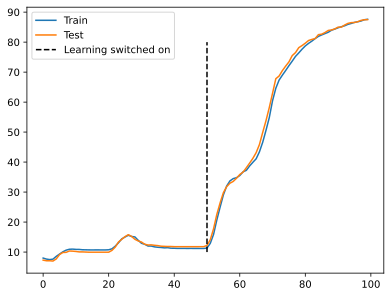

In [75]:
# create the network
net,lossfun,optimizer = createTheMNISTNet()

# train the model
trainAcc,testAcc,losses,net = function2trainTheModel(net,lossfun,optimizer)

plt.plot(trainAcc,label='Train')
plt.plot(testAcc,label='Test')
plt.plot([len(trainAcc)/2, len(trainAcc)/2],[10,80],'k--',label='Learning switched on')
plt.legend()
plt.show()
